In [6]:
%pip install -q ipywidgets

Note: you may need to restart the kernel to use updated packages.


This project uses Python's [MNE](https://mne.tools/stable/index.html) library to work with neurophysiological data, processing it and manupilating it to our needs and [scikit-learn](https://scikit-learn.org/stable/index.html) for the machine learning portion.

References:
- [IEEE's Deep Learning Architecture for Temporal Sleep Stage Classification Using Multivariate and Multimodal Time Series](https://ieeexplore.ieee.org/document/8307462)
- [Code from MNE Python Tutorial](https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py)
- [Yacine's tutorial, explanation and code](https://www.youtube.com/watch?v=0Msr2YBL0lE)
- [EDF and EDF+ deep dive](https://www.youtube.com/watch?v=DI7zfksrsCo&t=229s)
- [Proposed CNN methodology](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=10817107_pone.0297582.g001.jpg) (although we employ a random forest classifier instead of CNN for faster training and convergence)

# Analysis on 10 participant's EEG data and 3 sleep-stage classification

`EEG`: complex time series holds diff. kinds of data with diff. frequencies. (5 Bands)

`PSD` (Power spectrum density) : distribution of power across frequency components 

Classification objective: 
- Given the multimodal time series sleep data, detect which *sleep stage* a previously unseen participant is in any given 30 second epoch (epoch from the eeg data which can be collected directly in realtime using EEG headsets).

In [7]:
import mne
import numpy as np
import matplotlib.pyplot as plt

## Loading and preprocessing sleep data (fetch_data())

About the dataset:

> Fetched from the sleep physionet database, it is a 1995 study on age and gender effects in sleep EEG is recorded. It to a subset of 153 recordings from 37 males and 41 females that were 25-101 years old at the time of the recordings. 
There are two night recordings per subject except for subjects 13, 36 and 52 which have one record missing each due to missing recording hardware.

Data links: 
- 'https://www.physionet.org/content/sleep-edf/1.0.0/'
- 'https://academic.oup.com/sleep/article-abstract/18/7/557/2749691?redirectedFrom=fulltext&login=false' 

In [8]:
# Labels for Classification : for the 5 respective sleep stages + awake stage (W)
EVENT_ID = {
    "Sleep stage W" : 1,
    "Sleep stage 1/2/3/4" : 2,
    "Sleep stage R" : 3
    }


# No. of participants to analyze:
NUM_PARTICIPANT = 10

In [9]:
from mne.datasets.sleep_physionet.age import fetch_data
# from mne.datasets import fetch_dataset

# Function to load data
def load_eeg(participant_id, event_id=EVENT_ID):
    """
    Parser for EEG data. Will load EDF with their resp. annotations (for the given sample) and create 30 seconds epochs
    Returns: raw_edf : raw edf with annotations
    """
    # sleep stage event IDs for annotations
    ANNOTATION_EVENT_ID = {
        'Sleep stage W': 1,  # Wake (1)
        'Sleep stage 1': 2,  # 3 sleep stages (2)
        'Sleep stage 2': 2,  
        'Sleep stage 3': 2,  
        'Sleep stage R': 3   # Deep sleep (3)
        }
    
    [participant_file] = fetch_data(subjects=[participant_id], recording=[1], path="X:/Brainalytics/sleep_classifier/Data")

    # read the actual EDF signal file
    raw_edf = mne.io.read_raw_edf(
        participant_file[0],
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )

    # read the resp. annotation file
    annotation_edf = mne.read_annotations(participant_file[1])

    # Only 4hrs wake events before and after sleep kept (since data includes excessive awake data)
    annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 240, annotation_edf[-2]["onset"] + 30 * 240) # 30sec epochs for 240mins (4hrs)

    #Attach the annotation file to the raw edf loaded 
    raw_edf.set_annotations(annotation_edf, emit_warning=False)

    # Events of 30 seconds epochs created 
    events, _ = mne.events_from_annotations(raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0)

    # max time for epochs
    tmax = 30.0 - 1.0 / raw_edf.info["sfreq"] # tmax in included


    # Epochs for classification:
    epochs = mne.Epochs( # raw signal instace provided with events of 30 secs
        raw = raw_edf,
        events=events, 
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
        preload=True,
        )

    return raw_edf, events, epochs

In [10]:
# loading NUM_PARICIPANTS data, which are stored for later use
all_participants_epoch = []
for p_id in range(NUM_PARTICIPANT):
    raw_structured_edf, all_events, epochs = load_eeg(participant_id=p_id)
    all_participants_epoch.append(epochs)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1082 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1082 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1454 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1454 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1363 matching events found
No baseline correction applied
0 projection item

In [11]:
print("Training data EDF loaded and structured.")
raw_structured_edf

Training data EDF loaded and structured.


<RawEDF | SC4091E0-PSG.edf, 7 x 8196000 (81960.0 s), ~437.7 MiB, data loaded>

In [12]:
print("Training data events loaded and structured.")
all_events

Training data events loaded and structured.


array([[1695000,       0,       1],
       [1698000,       0,       1],
       [1701000,       0,       1],
       ...,
       [6195000,       0,       1],
       [6198000,       0,       1],
       [6201000,       0,       1]], shape=(1409, 3))

In [13]:
print("Training data epochs loaded and structured.")
epochs
# all_participants_epoch <- all epochs 

Training data epochs loaded and structured.


<Epochs | 1409 events (all good), 0 – 29.99 s (baseline off), ~225.8 MiB, data loaded,
 'Sleep stage W': 510
 'Sleep stage 1/2/3/4': 667
 'Sleep stage R': 232>

It can be seen that out of `1409` total recorded events we have 667 + 232 = `899` asleep and `510` awake events

In [14]:
# all NUM_PARTICIPANT epochs
all_participants_epoch

[<Epochs | 1082 events (all good), 0 – 29.99 s (baseline off), ~173.4 MiB, data loaded,
  'Sleep stage W': 548
  'Sleep stage 1/2/3/4': 409
  'Sleep stage R': 125>,
 <Epochs | 1454 events (all good), 0 – 29.99 s (baseline off), ~233.0 MiB, data loaded,
  'Sleep stage W': 517
  'Sleep stage 1/2/3/4': 767
  'Sleep stage R': 170>,
 <Epochs | 1363 events (all good), 0 – 29.99 s (baseline off), ~218.4 MiB, data loaded,
  'Sleep stage W': 488
  'Sleep stage 1/2/3/4': 712
  'Sleep stage R': 163>,
 <Epochs | 1311 events (all good), 0 – 29.99 s (baseline off), ~210.1 MiB, data loaded,
  'Sleep stage W': 500
  'Sleep stage 1/2/3/4': 602
  'Sleep stage R': 209>,
 <Epochs | 1595 events (all good), 0 – 29.99 s (baseline off), ~255.6 MiB, data loaded,
  'Sleep stage W': 560
  'Sleep stage 1/2/3/4': 839
  'Sleep stage R': 196>,
 <Epochs | 1013 events (all good), 0 – 29.99 s (baseline off), ~162.3 MiB, data loaded,
  'Sleep stage W': 568
  'Sleep stage 1/2/3/4': 377
  'Sleep stage R': 68>,
 <Epochs | 

Using matplotlib as 2D backend.


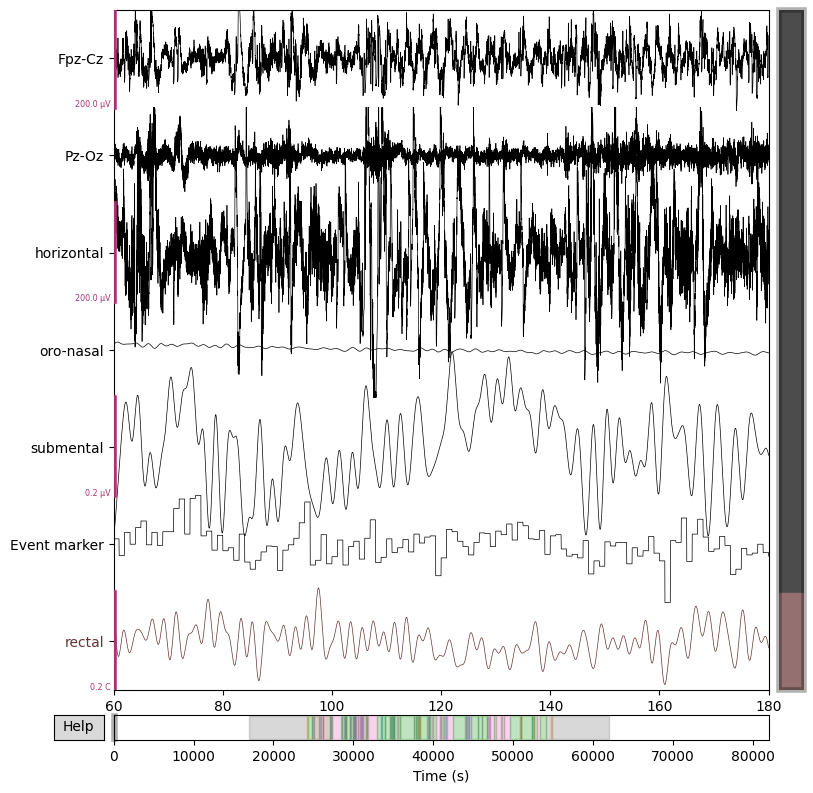

Aggregated plot showing the cumulative signals from all participants


In [15]:
raw_structured_edf.plot(
    start=60,
    duration=120,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)
)
print("Aggregated plot showing the cumulative signals from all participants")

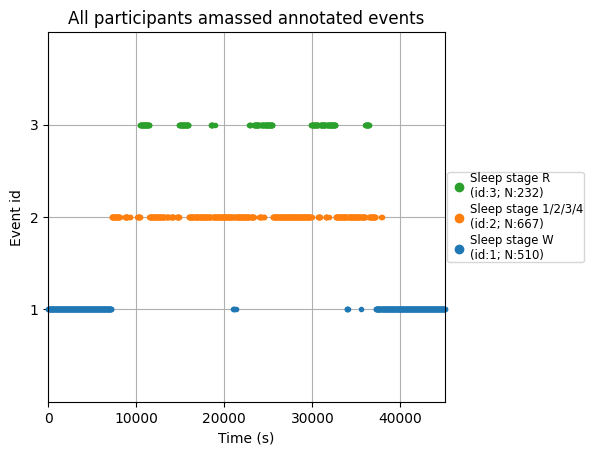

In [16]:
# events across time
fig = mne.viz.plot_events(
    all_events,
    event_id=EVENT_ID,
    sfreq=raw_structured_edf.info["sfreq"],
    first_samp=all_events[0, 0],
    show=False,
)
ax = fig.gca()

ax.set_title("All participants amassed annotated events")

# color-code contained in `stage_colors` for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.show()

In [17]:
# visualize participant 0 vs participant 1 PSD by sleep stage
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(EVENT_ID.keys())

for ax, title, epoch in zip([ax1, ax2], ["All participants"], [epochs]):
  for stage, color in zip(stages, stage_colors):
    spectrum = epoch[stage].compute_psd(fmin=0.1, fmax=30.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax,
        show=False,
        average=True,
        amplitude=False,
        spatial_colors=False,
        picks="data",
        exclude="bads",
    )
  ax.set(title=title, xlabel="Frequency (Hz)")

ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


## Features and target event markers calculation

In [18]:
# Frequency bands range in Hz for EEG
FREQ_BANDS = {
"delta": [0.5, 4.5],
"theta": [4.5, 8.5],
"alpha": [8.5, 11.5],
"sigma": [11.5, 15.5],
"beta": [15.5, 30],
}

In [19]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS): 
    """
    Calculate relative spectral analysis on the EEG sensors for each epochs
    Returns:
        X : concatenated array of filtered psd bands
    """
    
    # Calculate the spectrogram (default method used is multitaper)
    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True) # spectrum on each frequency
    
    # Normalization
    psds /= np.sum(psds, axis=-1, keepdims=True)
    
    # shape of PSDS:
    # (epoch, number of channels (we have two), frequency_bins)
    # We'll slice and average to get the delta to theta bands (5 feature per channel)
    # Therefore we should finish with (epoch, number of channels * number of bands(only the 5 we are considering))
    
    X = []
    # Average
    # For each frequency band get the mean value and add it to the list X
    for fmin, fmax in freq_bands.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1) # psds_band : avg. across bands (.mean) for all epochs 
        X.append(psds_band.reshape(len(psds), -1))
        
    #return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
    return np.concatenate(X, axis=1)

In [20]:
# Iterating over 30sec epochs, calc. the proper powerband features
# Then define the right id for the 'group' which should be the participant_id

X = []
y = []
groups = [] # for LeaveOneOut CV scheme, by matching ids with participant_id

for group_id, epochs in enumerate(all_participants_epoch):
    print(f"Processing participant #{group_id}")

    X_epoch = eeg_power_band(epochs)
    y_epoch = epochs.events[:, 2]
    group_epoch = [group_id] * len(y_epoch)

    X.append(X_epoch)
    y.append(y_epoch)
    groups.append(group_epoch)


# Transform these lists into numpy array with proper size for sklearn models
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
groups = np.concatenate(groups, axis=0)

Processing participant #0
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #1
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #2
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #3
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #4
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #5
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #6
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #7
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #8
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participant #9
    Using multitaper spectrum estimation with 7 DPSS windows


## Classification with LeaveOneGroupOut cross validation scheme

In [21]:
X

array([[7.62920082e-03, 6.19426557e-03, 4.32374329e-04, ...,
        3.18124272e-04, 4.12920347e-05, 1.21957133e-04],
       [6.86465488e-03, 4.92190383e-03, 9.42741080e-04, ...,
        3.33860092e-04, 8.13732050e-05, 1.52939435e-04],
       [6.93429531e-03, 4.75221607e-03, 8.06494064e-04, ...,
        3.58648356e-04, 9.78961311e-05, 1.89692010e-04],
       ...,
       [6.68607030e-03, 1.66794798e-03, 5.10893263e-04, ...,
        1.09227570e-03, 2.03658533e-04, 9.40636607e-04],
       [6.75338450e-03, 2.09339927e-03, 4.05237831e-04, ...,
        1.07971487e-03, 2.23266948e-04, 9.21745573e-04],
       [6.93193948e-03, 2.02486775e-03, 5.92351661e-04, ...,
        9.13516604e-04, 1.31698138e-04, 9.39920787e-04]],
      shape=(12885, 10))

In [22]:
y

array([1, 1, 1, ..., 1, 1, 1], shape=(12885,))

In [23]:
groups

array([0, 0, 0, ..., 9, 9, 9], shape=(12885,))

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneGroupOut

# Leave One Participant Out Cross Validation, using group_id == participant_id
logo = LeaveOneGroupOut()
group_id = 0

for train, test in logo.split(X, y, groups=groups):
  print(f"Testing on participant: #{group_id}")
  group_id = group_id + 1

  # Training of the classifier # Perform some HYPT
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  X_train = X[train]
  y_train = y[train]
  model.fit(X_train, y_train)

  # Testing using the current participant data left out
  X_test = X[test]
  y_test = y[test]
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)

  print(f"Accuracy score: {acc}")

  # Create a confusion matrix and a report on all the metrics
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot() # will appear at the end of the output

  print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
  print(EVENT_ID)

Testing on participant: #0
Accuracy score: 0.8733826247689463
                     precision    recall  f1-score   support

      Sleep stage W       1.00      0.87      0.93       548
Sleep stage 1/2/3/4       0.84      0.91      0.87       409
      Sleep stage R       0.61      0.77      0.68       125

           accuracy                           0.87      1082
          macro avg       0.81      0.85      0.83      1082
       weighted avg       0.89      0.87      0.88      1082

{'Sleep stage W': 1, 'Sleep stage 1/2/3/4': 2, 'Sleep stage R': 3}
Testing on participant: #1
Accuracy score: 0.8789546079779917
                     precision    recall  f1-score   support

      Sleep stage W       0.85      1.00      0.92       517
Sleep stage 1/2/3/4       0.95      0.81      0.88       767
      Sleep stage R       0.71      0.81      0.76       170

           accuracy                           0.88      1454
          macro avg       0.84      0.87      0.85      1454
       weig

**This shows are the accuracy to be as high as 92% on the 6th candidate and as low as 86% on the 9th candidate**